### About the dataset - U.S. Clinical Trials (2000-2020)

This dataset was obtained from https://clinicaltrials.gov/ct2/results?cond=&term=&cntry=US&state=&city=&dist= .

Useful links defining the terms within the dataset: 
https://clinicaltrials.gov/ct2/manage-recs/resources#DataElement
https://prsinfo.clinicaltrials.gov/definitions.html#PrimaryCompletionDate

## PREDICTION OF CLINICAL TRIAL DURATION

## Table of Contents

* [1-Imports](#first-bullet)
* [2 - Preparation and inspection of the dataframe](#second-bullet)
* [3-What is the operating and recruitment status of clinical trials?](#third-bullet)
* [4 - Clinical trial duration](#fourth-bullet)
* [5 - What indications are trials focusing on?](#fifth-bullet)
* [6 - FEATURE ENGINEERING FOR PREDICTION OF TRIAL DURATION](#sixth-bullet)
* [7 - MODELS](#seventh-bullet)


## 1 - Imports <a class="anchor" id="first-bullet"></a>

In [1]:
import pandas as pd
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import string
import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier

## 2 - Preparation and inspection of the dataframe <a class="anchor" id="second-bullet"></a>

In [2]:
# Each .csv file consists of data from a year. This code concatenates dataframe from all 20 years.

files = glob.glob('20*_SearchResults.csv')
df_list = []
for file in files:
    df = pd.read_csv(file)
    df_list.append(df)

trials_df = pd.concat(df_list, ignore_index=True)   

#### Total number of records in the dataframe : 122731

In [3]:
len(trials_df)

122731

In [4]:
trials_df.head(3)

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,...,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04296266,Human Salivary Gland Disposition of Alda-341 i...,NaN,Completed,No Results Available,Submandibular Gland Tumor|Parotid Gland Tumor,Drug: Alda-341,Bioavailability of Alda-341 in salivary gland ...,Stanford University,...,IRB-32994,February 2016,"December 18, 2017","December 21, 2017","March 5, 2020",NaN,"March 5, 2020","Stanford University, Stanford, California, Uni...",NaN,https://ClinicalTrials.gov/show/NCT04296266
1,2,NCT04294303,Use of Telemonitoring System in Heart Failure ...,I get better,Completed,No Results Available,Heart Failure|Quality of Life,Other: web based telemonitoring system|Other: ...,Rate of hospital readmission for heart failure...,Danbury Hospital,...,15-608,"February 3, 2016","April 11, 2018","January 29, 2020","March 4, 2020",NaN,"March 5, 2020","Danbury Hospital, Danbury, Connecticut, United...",NaN,https://ClinicalTrials.gov/show/NCT04294303
2,3,NCT04284930,Comparison of Local Anesthetic Infusion Pump V...,NaN,Completed,No Results Available,"Pain, Postoperative",Drug: Depobupivacaine|Drug: OnQ pump|Drug: 0.2...,6 Hour Post-op Pain Morphine or Hydromorphone ...,The Cleveland Clinic,...,15-1535,February 2016,November 2017,November 2017,"February 26, 2020",NaN,"February 26, 2020","Cleveland Clinic Foundation, Cleveland, Ohio, ...",NaN,https://ClinicalTrials.gov/show/NCT04284930


## 3 - What is the operating and recruitment status of clinical trials? <a class="anchor" id="third-bullet"></a>

In [5]:
trials_df['Status'].unique()

array(['Completed', 'Recruiting', 'Active, not recruiting', 'Terminated',
       'Enrolling by invitation', 'Withdrawn', 'Unknown status',
       'Suspended', 'Not yet recruiting', 'No longer available',
       'Approved for marketing', 'Available'], dtype=object)

Text(0.5, 1.0, 'Figure 1 - Status of clinical trials')

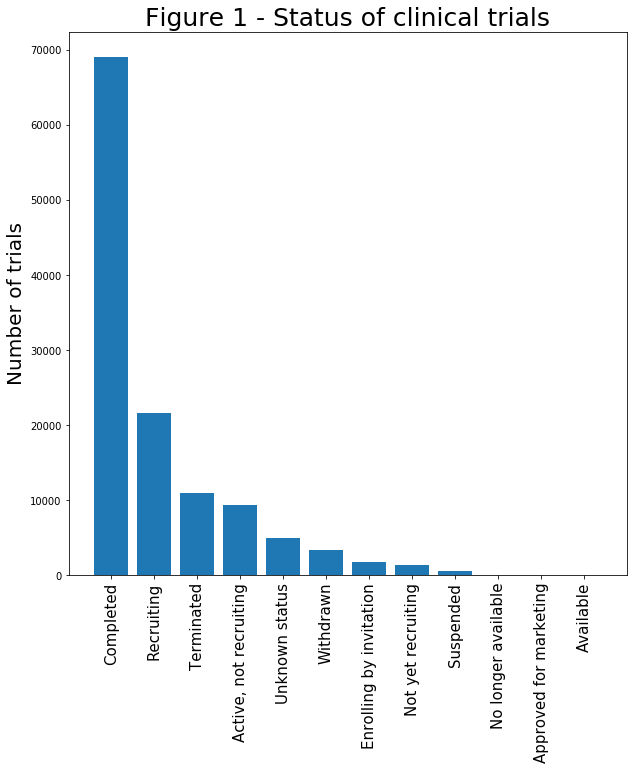

In [6]:
status_bar = trials_df['Status'].value_counts()
plt.figure(figsize=(10,10))
ax1 = plt.subplot()
x_labels = status_bar.index
y_values = status_bar.values
plt.bar(x_labels, y_values)
ax1.set_xticks(range(len(status_bar)))
ax1.set_xticklabels(x_labels, rotation=90, fontsize=15)
plt.xlabel('', fontsize=20)
plt.ylabel('Number of trials', fontsize=20)
plt.title('Figure 1 - Status of clinical trials', fontsize = 25)

## What are the participant age-groups ?

In [7]:
# Take the Age column and further split it into 'Age range', 'Demographic'. eg. Demographic would be either 'Mixed',
#'Adult', or 'Child'

def age_assess(age_string):
    if 'Child' in age_string and 'Adult' not in age_string:
        return 'Pediatric'
    elif 'Child' in age_string and 'Adult' in age_string:
        return 'Mixed'
    else:
        return 'Adult'
    
trials_df['age_group'] = trials_df['Age'].apply(age_assess)
trials_df['age_group'].value_counts().values

array([99170, 16399,  7162])

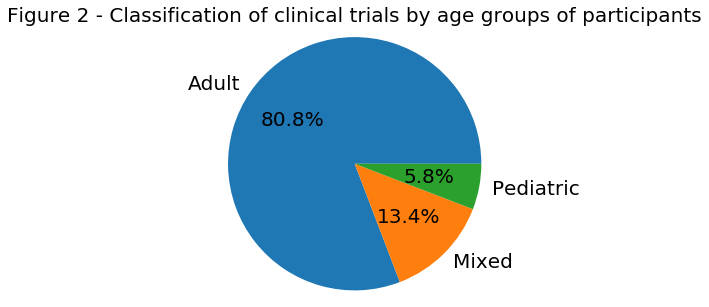

In [8]:
plt.figure(figsize=(5,5))
plt.subplot()
plt.pie(trials_df['age_group'].value_counts().values, labels = trials_df['age_group'].value_counts().index, autopct = '%0.1f%%', textprops={'fontsize': 20})
plt.axis('equal')
plt.title('Figure 2 - Classification of clinical trials by age groups of participants', fontsize=20)
plt.show()

## 4 - Clinical trial duration <a class="anchor" id="fourth-bullet"></a>

(4.1) New column 'trial_duration' was added to calculate trial duration using Start Date and Completion Date.
Trial records with null duration values were dropped.

In [10]:

trials_df['Start Date'] = pd.to_datetime(trials_df['Start Date'])
trials_df['Completion Date'] = pd.to_datetime(trials_df['Completion Date'])
trials_df['trial_duration'] = trials_df['Completion Date']-trials_df['Start Date']
trials_df = trials_df.dropna(subset=['trial_duration'])

# Added a new column 'duration_days' that has only numerical data.
trials_df['duration_days'] = trials_df['trial_duration'].dt.days
trials_df = trials_df[trials_df['duration_days'] != 0]
trials_df['duration_days'].describe()


count    117349.000000
mean       1283.588688
std        1225.149900
min           1.000000
25%         515.000000
50%        1004.000000
75%        1706.000000
max       35794.000000
Name: duration_days, dtype: float64

In [11]:
trials_df['duration_days'].mean()
frequency, bins = np.histogram(trials_df['duration_days'], bins=20) #, bins=20, #range=[100, 4000])
frequency
bins
# Maximum frequency is 280 and the corresponding duration is 685 days. 

array([1.000000e+00, 1.790650e+03, 3.580300e+03, 5.369950e+03,
       7.159600e+03, 8.949250e+03, 1.073890e+04, 1.252855e+04,
       1.431820e+04, 1.610785e+04, 1.789750e+04, 1.968715e+04,
       2.147680e+04, 2.326645e+04, 2.505610e+04, 2.684575e+04,
       2.863540e+04, 3.042505e+04, 3.221470e+04, 3.400435e+04,
       3.579400e+04])

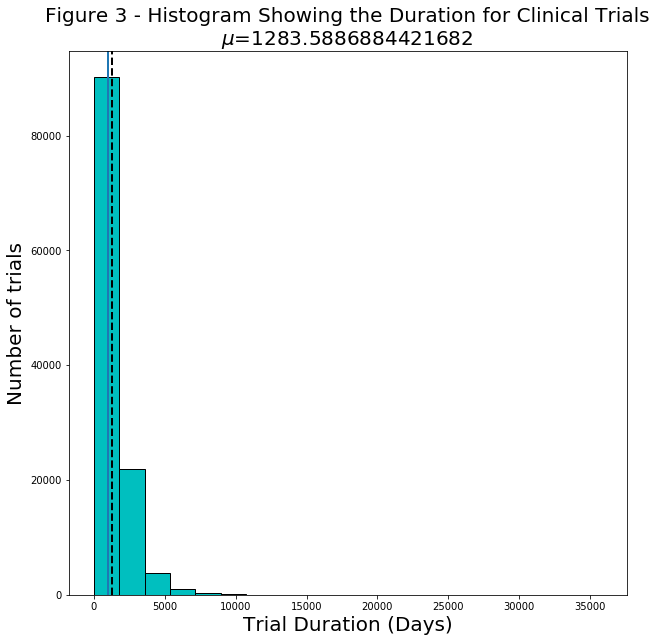

In [12]:

f2, ax2 = plt.subplots(figsize=(10,10))
ax2 = plt.hist(trials_df['duration_days'], bins = 20, color = 'c', edgecolor='black')
plt.xlabel('Trial Duration (Days)', fontsize=20)
plt.ylabel('Number of trials', fontsize=20)
plt.axvline(trials_df['duration_days'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(trials_df['duration_days'].median(),linewidth=2)
plt.title('Figure 3 - Histogram Showing the Duration for Clinical Trials\n' r'$\mu$' '='+ str(trials_df['duration_days'].mean()), fontsize=20)
plt.show()

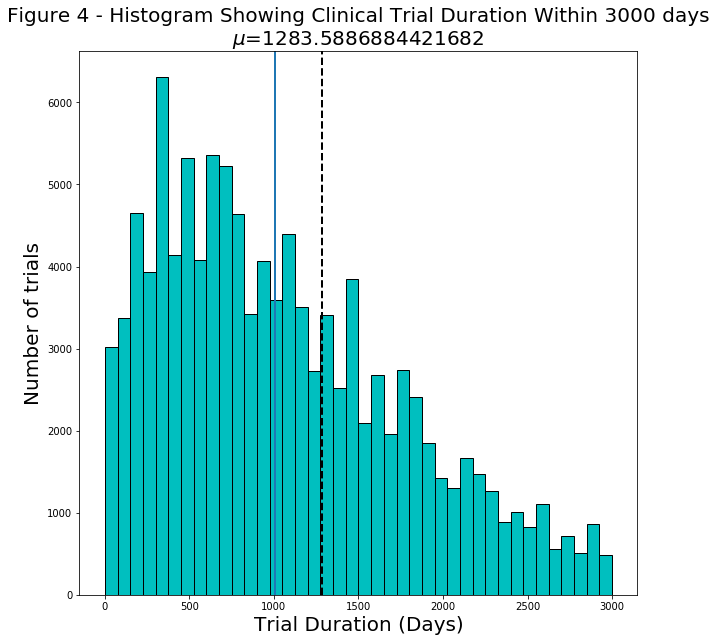

In [13]:
f4, ax4 = plt.subplots(figsize=(10,10))
ax4 = plt.hist(trials_df['duration_days'], range = (0,3000), bins = 40, color = 'c', edgecolor='black')
plt.xlabel('Trial Duration (Days)', fontsize=20)
plt.ylabel('Number of trials', fontsize=20)
plt.axvline(trials_df['duration_days'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(trials_df['duration_days'].median(),linewidth=2)
plt.title('Figure 4 - Histogram Showing Clinical Trial Duration Within 3000 days\n' r'$\mu$' '='+ str(trials_df['duration_days'].mean()), fontsize=20)
plt.show()

### >>> INSIGHT : Trial duration is skewed and since there are trials that are taking longer than 10 years to complete, these dat points might affect prediction.

## 5 - What indications are trials focusing on? <a class="anchor" id="fifth-bullet"></a>

(5.1) This question required a lot of data extraction and classification. First, a master dictionary of terms specific to each indication or major body systems was created. Then the 'Conditions' column was used to extract all possible disorders covered within the trial. The main challenge was that trials were rarely exclusive to 1 condition. Eg. trial looking at amnesia in lung cancer patients.

### EXAMPLE: 
Benign Cysts Ovarian|Cystectomy|Torsion|Malignant Cysts Ovarian

Sleep Disordered Breathing|Sleep Hypopnea|Sleep Apnea|Sleep Apnea, Obstructive|Snoring

#### PROCESSED TO:
['cancer']

['sleep', 'ent']

#### Create a dictionary with a broad category as the key and a list of corresponding terms as the values.

In [14]:
master_dict = {'cardiac': ['cardiovascular', 'mitral','aortic','coronary', 'heart', 'cardio',
                           'cardiac', 'arrhythmia', 'afib','fibrillation','tachycardia', 'myocardial'],
               
               'cancer' : ['cancer', 'cancers', 'tumors','tumour', 'tumours','malignant', 'oncogenic', 'oncology',
                           'neoplasms', 'neoplasm','malignancy', 'leukemia', 'oma', 'leukaemia',
                           'tumor', 'aml', 'cml','chemotherapy', 'metastases','nsclc', 'malignancies'],
               
               'accident' : ['accident', 'accidental','fall'],
               
               'respiratory' : ['respiratory', 'copd', 'bronchitis', 'emphysema', 'crd', 'asthma',
                                        'lung', 'pulmonary', 'pleural',
                                        'airway', 'lung'],
               
               'stroke' : ['cerebrovascular', 'stroke', 'ischemic', 'tia', 'attack','hemorrhage', 'cerebral'],
               
               'alzheimers disease' : ['alzheimer\'s', 'dementia', 'alzheimer','alzheimers'],
               
               'diabetes' : ['diabetes', 'diabetic', 'insulin','mellitus','Type1diabetes'],
               
               'influenza/pneumonia' : ['influenza', 'pneumonia','flu'],
               
               'kidney/urinary' : ['nephritis', 'nephrosis', 'nephrotic', 'kidney','renal', 'urethra', 'urethral',
                                     'urologic','urinary','bladder', 'catheter', 'catheterization', 'incontinence'],
               
               'suicide' : ['suicide', 'suicidal'], 
               
              'mental health': ['psychological','mental','depression', 'anxiety', 'bipolar', 'dementia', 'dementias', 
                                'schizophrenia', 'violence','emotion','emotional','empathy', 'burnout', 'psychiatric',
                                'ataxia','delirium','ocd','psychotic', 'eating', 'compulsive', 'autism', 'behavioral', 'adhd',
                                'psychosis', 'mood', 'personality', 'bulimia', 'binge', 'anorexia', 'stress', 'psychological',
                                'behavior', 'cognition', 'cognitive', 'depressive','ptsd','attention','autistic'],
               
              'pregnancy': ['pregnant', 'pregnancy','gestational','birth','fetal', 'fetus','labor', 'placental', 'placenta',
                            'breastfeeding','abortion','postpartum', 'prenatal', 'umbilical', 'amniotic', 'gestation','eclampsia'],
               
              'addiction': ['abuse','alcohol', 'drinking', 'tobacco', 'drug', 'opioid', 'narcotic', 'alcoholic', 'cig',
                        'smoking', 'hookah', 'cannabis', 'gambling', 'vaping', 'opiate', 'cocaine', 'substance',
                        'cbd', 'marijuana', 'cigarette', 'cigarettes','intoxication','alcoholism','nicotine','smoker','smokers'],
               
              'sleep': ['sleep', 'insomnia', 'sleepiness', 'circadian'],
               
              'obesity': ['obesity','obese','overweight'],
               
              'pain/injury': ['trauma', 'injury', 'pain', 'injuries','tear','fracture','fractures',
                              'burn','burns','wound','rotator','acl', 'concussion'],
               
              'nervous system/muscular': ['fibromyalgia','neuropathy','neural','parkinson\'s', 'musculo', 'myasthenia',
                                          'parkinson','sclerosis', 'muscle', 'spinal', 'carpal', 'neuro', 'nerve',
                                          'tremor','spine','neurological','neuromuscular','muscular', 'headache', 'brain', 
                                          'migraine','reflex','als','epilepsy','cervical','dystrophy','csf', 'lumbar'],
               
              'infection/immunity': ['infections', 'infection', 'infectious', 'bacteria', 'bacterial', 'viral', 'tuberculosis',
                            'sepsis','mrsa','transplant', 'gvhd','hiv', 'aids','virus', 'fungal', 'fungus', 'dengue',
                            'septic', 'itis','malaria','typhoid','lyme','gonorrhea','pathogen', 'diphtheria', 'thymus', 'thymic', 'spleen',
                            'pathogenic','pathogens','graft','lupus', 'allergy', 'allergic', 'herpes', 'marrow', 'vaccine',
                                  'splenic', 'hypersensitivity','inflammation', 'inflammatory','clostridium', 'hpv', 'staphylococcus', 
                                    'pox', 'strep', 'immune', 'immunity', 'autoimmune', 'antibody', 'vaccination'],
               
              'gastrointestinal/digestive': ['constipation', 'ulcer', 'gastrointestinal', 'gastro', 'intestinal', 'colonoscopy',
                                   'bowel','colonic', 'gastric','crohn', 'crohn\'s', 'celiac', 'diarrhea', 'stool',
                                  'digestive', 'digestion', 'colorectal', 'rectal', 'anal'],
               
               'endocrine' : ['endocrine', 'hormone', 'hormonal', 'paracrine', 'pituitary', 'thyroid', 'adrenal', 
                              'pancreas', 'pancreatic'],
               
              'healthy volunteers': ['healthy','health','normal'],
               
              'blood/hematological': ['blood','heme', 'hematologic', 'plasma', 'anemia', 'hemophilia', 'artery', 'arteries',
                                      'pvd', 'vascular', 'venous','vein','veins','arterial','endothelial', 'dvt', 'vessel',
                                      'bleeding','hypertension','sickle','thrombosis','thrombocythemia',
                                     'willebrand','eosinophil','eosinophils','neutrophils','neutrophil', 'myelodysplastic'],
               
              'hepatic': ['liver', 'hepatitis','hepatic','nafld','cirrhosis'],
               
               'skeletal' : ['arthritis', 'rheumatoid','knee', 'bone', 'joint', 'bones', 'joints', 'osteo', 'skeletal', 'cranium',
                            'cranial', 'skull'],
               
              'aging': ['aging', 'age', 'age-related','hospice'],
               
              'skin': ['skin','psoriasis','acne','eczema','rosacea', 'wrinkle', 'keratin', 'hair', 'alopecia'],
               
              'metabolic': ['metabolic','metabolism','fructose','hypoglycemia',
                            'hyperlipidemia','glucose','lactose'],
               
              'genetic disorders': ['cystic', 'down', 'down\'s','genetic'],
               
              'deficiency/nutritional': ['deficiency', 'diet', 'dietary', 'nutrition', 'nutritional'],
               
              'eye disorders': ['eye', 'myopic','vision','blindness','cataract','astigmatism', 'refractive', 
                                'ocular', 'cornea', 'corneal'],
               
              'dental': ['dental', 'tooth', 'teeth', 'enamel','gingival','root'],
               
              'reproductive/gender-specific': ['fertility', 'infertility','pcos','ovary','uterus', 'uterine',
                               'endometriosis','menopause','menopausal','contraceptive','contraception', 
                                               'vaginal','prostatic', 'prostate', 'testes', 'testicular',
                                               'contraceptive','penile','erectile','sexual'],
               
              'ent': ['ear','hearing','motion','abdominal','cochlear','nasal','sinusitis','apnea', 'blind', 'blindness',
                      'thyroid','oral','vocal','nausea','thorax','thoracic','lip','sinus', 'throat', 'nose', 'deaf', 'deafness'],
                              
              'pediatric/infant': ['infant', 'infants','infantile','pediatric','neonatal','congenital']}


#### Swap the previous dictionary key-value pairs i.e. each term now points to a disease category.

In [15]:
# Create a dictionary with different alternative/keywords corresponding to the main classifying disease.

#coi = condition of interest

disease_dictionary = {}

for coi,terms in master_dict.items():
    disease_value = coi
    for term in terms:
        disease_dictionary[term] = disease_value

#### A function that takes a single word as a query and tags it with the main disease category.

In [16]:
# Write a function that takes a single word as a query and classifies it 
# Ignores hyphenated words
# Only handles words - will not handle 'anxiety,depression'

def word_to_disease(query_word, source_dict):
    empty_set = set()
    ignore_words = ['the', 'on', 'of', 'to', 'like', 'in', 'for']
    query_word = query_word.strip(string.punctuation)
    if query_word in source_dict:
        empty_set.add(source_dict.get(query_word))
    elif query_word in ignore_words:
        return empty_set
    elif query_word.rstrip('s') in source_dict:
        empty_set.add(source_dict.get(query_word.rstrip('s')))
    elif query_word[-3:]=='oma' or query_word.rstrip('s')[-3:] == 'oma':
        empty_set.add(source_dict.get('oma'))
    elif query_word[-4:] == 'itis':
        empty_set.add(source_dict.get('itis'))
    elif 'osteo' in query_word:
        empty_set.add(source_dict.get('osteo'))
    elif 'gastro' in query_word:
        empty_set.add(source_dict.get('gastro'))
    elif 'hepato' in query_word:
        empty_set.add(source_dict.get('hepatic'))
    elif 'laryngo' in query_word or 'broncho' in query_word:
        empty_set.add(source_dict.get('lung'))
    elif 'angio' in query_word or 'thrombo' in query_word:
        empty_set.add(source_dict.get('blood'))
    elif 'cardio' in query_word or 'cardiac' in query_word:
        empty_set.add(source_dict.get('heart'))
    elif 'neuro' in query_word:
        empty_set.add(source_dict.get('neuro'))
    elif 'cranial' in query_word or 'cranio' in query_word:
        empty_set.add(source_dict.get('cranial'))
    elif 'thyroid' in query_word:
        empty_set.add(source_dict.get('thyroid'))
    return empty_set
        
# TEST/EXAMPLE:        
result1 = word_to_disease('intracranial', disease_dictionary)   
result2 = word_to_disease('thrombocytopenia', disease_dictionary)
print(result1.union(result2))

{'skeletal', 'blood/hematological'}


#### A function that assesses a string and uses the 'word_to_disease' function to arrive at a set consisting of main disease categories.

In [17]:
# Improvement of the previous classifier disease_classifier1

# Disregard hyphenated words - don't split them as there is a higher chance of false positives if the word is split.
# DISEASE CLASSIFIER 2
# This function requires : IMPORT string
# Moral Injury|Anxiety|Depression|Burn-Out Acromegaly
                                                                                           
def disease_classifier2(query_string):
    classified_set = set() # Create an empty set???
    cleaned_query = query_string.replace('|', ' ').replace(',', ' ').replace(';', ' ').replace(':', ' ').replace('/', ' ').replace('-', ' ').lower()
    cleaned_string = cleaned_query.lower().split(' ') # Creates a list of entries ['moral', injury', 'cancer', 'burn-out acromegaly']
    for word in cleaned_string:
        x = word_to_disease(word, disease_dictionary)
        classified_set = classified_set.union(x)       
    if len(classified_set) == 0:
        classified_set.add('not classified')
        return list(classified_set)
    else:
        return list(classified_set)
        
# TEST/EXAMPLE:
disease_classifier2('neuropathy')

['nervous system/muscular']

### Add a new column that mentions a list of disease categories. 

In [18]:
# Add a new column to the raw_trials dataframe. This column should specify a broader disease category.
trials_df['disease_classification'] = trials_df['Conditions'].apply(disease_classifier2)


In [19]:
# Expands the list from each 'disease_classified' row:

disease_categories = trials_df['disease_classification'].explode()

#set1 = {'cancer', 'heart', 'obesity'}

diseases_counts = disease_categories.value_counts()
#diseases_bar = diseases_counts.head(11)

#diseases_x = diseases_counts.index
#diseases_y = diseases_counts.values

disease_labels = diseases_counts[diseases_counts.index != 'not classified'].index
# for label in disease_labels:
#     print(label)
    

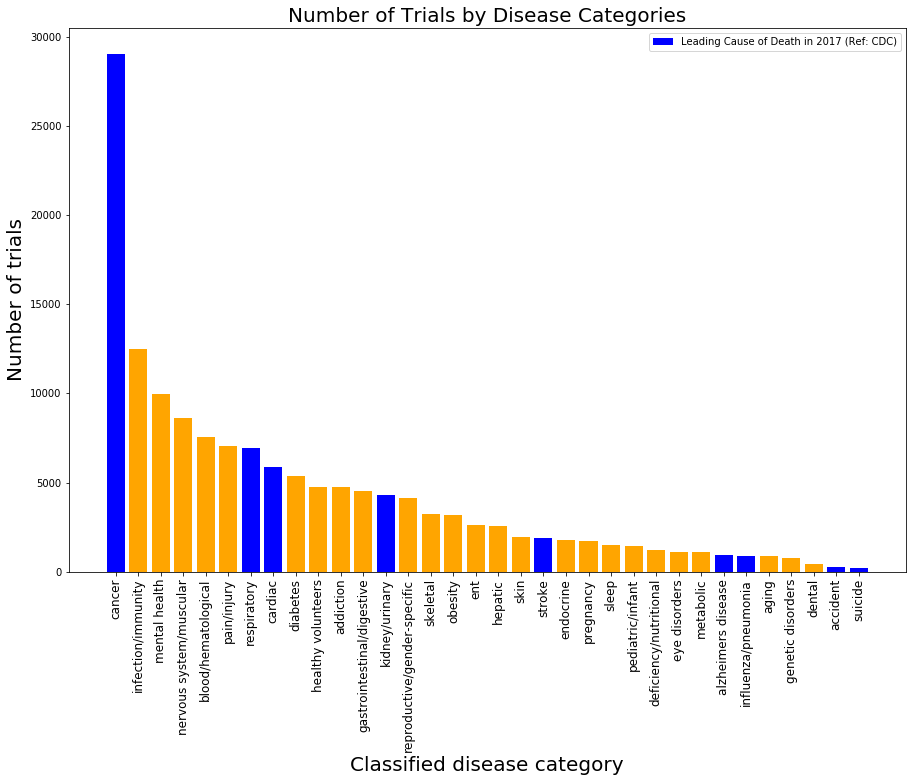

In [20]:
# Write a function that tags the disease categories that include the top ten causes of death (CDC) as red. 
# Don't plot categoies that are not classified.
#diseases_counts is a Series
# cdc_topten is a list of top leading causes of death, 2017

cdc_topten = ['cancer', 'cardiac', 'respiratory', 'kidney/urinary', 'stroke', 'alzheimers disease', 'suicide', 'influenza/pneumonia', 'accident']

# PREPARE INPUTS AND PARAMETERS FOR THE BAR GRAPH:

# Y values are the number of trials
trial_values = diseases_counts[diseases_counts.index != 'not classified'].values

# X values are range of the number of categories
disease_values = range(len(trial_values))

# X labels are disease labels
disease_labels = diseases_counts[diseases_counts.index != 'not classified'].index

# A lambda function for assigning blue if the category contains one of the top ten leading causes of death.
disease_color = ['blue' if disease in cdc_topten else 'orange' for disease in disease_labels]

# MAKE THE PLOT:
plt.figure(figsize=(15,10))
ax3 = plt.subplot()
plt.bar(disease_labels, trial_values, color = disease_color)
ax3.set_xticks(disease_values)
ax3.set_xticklabels(disease_labels, rotation=90, fontsize = 12)
plt.xlabel('Classified disease category', fontsize=20)
plt.ylabel('Number of trials', fontsize=20)
plt.title('Number of Trials by Disease Categories', fontsize = 20)
plt.legend(['Leading Cause of Death in 2017 (Ref: CDC)', 'XYZ'])
plt.show()

## 6 - FEATURE ENGINEERING FOR PREDICTION OF TRIAL DURATION <a class="anchor" id="sixth-bullet"></a>

### Features

#### Number of participants (numerical)
#### Participant demographic (age - adult/pediatric, male/female ---> converted to binary data)
#### Disease/Body systems involved (Based on the classification performed above ---> classified as 1 or 0)
#### Type of interventions tested (Drug/device/Biological/Dietary Supplement/Radiation, etc. ---> classified as 1 or 0)
#### Number of outcomes that are measured (Complex strings --> numerical data ---> z score normalization)
#### Phase number (Phase 0/1/2/3/4 ---> classified as 1 or 0)


#### 6.1 - Feature engineering - Interventions

In [21]:

def intervention_classifier(string):
    int_set = set()
    if string == 'none':
        int_set.add('none')
        return list(int_set)
    string_list = string.split('|') 
    for element in string_list:
        if ':' in element:            
            keyword = element[:element.find(':')]
            int_set.add(keyword.lower())
        else:
            int_set.add('none')
    if len(int_set) == 0:
        int_set.add('none')
        return list(int_set)
    return list(int_set)
    

In [22]:
trials_df['Interventions'] = trials_df['Interventions'].fillna('none')
trials_df['int_classification'] = trials_df['Interventions'].apply(intervention_classifier)


In [44]:
int_columnnames = ['drug', 'device', 'procedure', 'biological', 'radiation', 'diagnostic', 'behavioral', 'dietary', 'other']
for keyword in int_columnnames:
    name = 'is_' + keyword
    if keyword == 'dietary':
        trials_df[name] = trials_df['int_classification'].apply(lambda x: 1 if 'dietary supplement' in x else 0)
    elif keyword == 'diagnostic':
        trials_df[name] = trials_df['int_classification'].apply(lambda x: 1 if 'diagnostic test' in x else 0)
    else:
        trials_df[name] = trials_df['int_classification'].apply(lambda x: 1 if keyword in x else 0)

#### 6.2 - Feature engineering - Gender

In [45]:
trials_df['Gender'] = trials_df['Gender'].fillna('all')
trials_df['Gender'].value_counts()

All       101729
Female     11013
Male        4544
all           63
Name: Gender, dtype: int64

In [46]:
trials_df['is_male'] = trials_df['Gender'].apply(lambda x: 1 if x == 'Male' or x == 'all' or x == 'All' else 0)
trials_df['is_female'] = trials_df['Gender'].apply(lambda x: 1 if x == 'Female' or x == 'all' or x == 'All' else 0)

In [47]:
trials_df['is_adult'] = trials_df['age_group'].apply(lambda x: 1 if x == 'Adult' or x == 'Mixed' else 0)
trials_df['is_pediatric'] = trials_df['age_group'].apply(lambda x: 1 if x == 'Pediatric' or x == 'Mixed' else 0)

#### 6.3 - Feature engineering - Number of outcomes measured

In [48]:
trials_df['Outcome Measures'] = trials_df['Outcome Measures'].fillna('none')

In [49]:
def count_outcomes(string):
    count = 0
    if string == 'none':
        return 0
    elif '|' not in string:
        return 1
    elif '|' in string:
        return string.count('|') + 1


In [50]:
trials_df['number_outcomes'] = trials_df['Outcome Measures'].apply(count_outcomes)

#### 6.4 - Feature engineering - Phase of study

In [51]:
trials_df['Phases'] = trials_df['Phases'].fillna('none')

In [52]:

phase_dictionary = {'is_phase0': 'Early Phase 1','is_phase1' : 'Phase 1', 'is_phase2' : 'Phase 2', 'is_phase3' : 'Phase 3', 'is_phase4' : 'Phase 4'}

def phase_subcolumns(phase_dictionary, df):
    for subcolumn in phase_dictionary.keys():
        df[subcolumn] = df['Phases'].apply(lambda x: 1 if phase_dictionary.get(subcolumn) in x else 0)
phase_subcolumns(phase_dictionary, trials_df)


#### 6.5 - Feature engineering -Number of people enrolled/required

In [53]:
trials_df['Enrollment'] = trials_df['Enrollment'].fillna(trials_df['Enrollment'].median())

#### 6.6 - Feature engineering - diseases/body systems involved

In [54]:
disease_columnnames = list(master_dict.keys())
for keyword in disease_columnnames:
    name = 'is_' + keyword
    trials_df[name] = trials_df['disease_classification'].apply(lambda x: 1 if keyword in x else 0)

#### 6.7 - Normalization


In [55]:
# Enrollment
trials_df['Enrollment'].isna().value_counts()
enrollment_mean = trials_df['Enrollment'].mean()
enrollment_std = trials_df['Enrollment'].std()

trials_df['normalized_enrollment'] = trials_df['Enrollment'].apply(lambda x: (x-enrollment_mean)/enrollment_std)


In [56]:
# number_outcomes
trials_df['number_outcomes'].isna().value_counts()
numoutcomes_mean = trials_df['number_outcomes'].mean()
numoutcomes_std = trials_df['number_outcomes'].std()

trials_df['normalized_numoutcomes'] = trials_df['number_outcomes'].apply(lambda x: (x-numoutcomes_mean)/numoutcomes_std)


## 7 - MODELS <a class="anchor" id="seventh-bullet"></a>

#### Feature combinations

In [57]:
features_all = ['is_male', 'is_female', 'is_phase0', 'is_phase1', 'is_phase2', 'is_phase3', 
              'is_phase4', 'is_adult', 'is_pediatric', 'is_cardiac', 'is_cancer',
       'is_accident', 'is_respiratory', 'is_stroke', 'is_alzheimers disease',
       'is_diabetes', 'is_influenza/pneumonia', 'is_kidney/urinary',
       'is_suicide', 'is_mental health', 'is_pregnancy', 'is_addiction',
       'is_sleep', 'is_obesity', 'is_pain/injury',
       'is_nervous system/muscular', 'is_infection/immunity',
       'is_gastrointestinal/digestive', 'is_endocrine',
       'is_healthy volunteers', 'is_blood/hematological', 'is_hepatic',
       'is_skeletal', 'is_aging', 'is_skin', 'is_metabolic',
       'is_genetic disorders', 'is_deficiency/nutritional', 'is_eye disorders',
       'is_dental', 'is_reproductive/gender-specific', 'is_ent',
       'is_pediatric/infant', 'is_drug', 'is_device', 'is_procedure',
       'is_biological', 'is_radiation', 'is_diagnostic', 'is_behavioral',
       'is_dietary', 'is_other']

features_nodiseases = ['is_male', 'is_female', 'is_phase0', 'is_phase1', 'is_phase2', 'is_phase3', 
              'is_phase4', 'is_adult', 'is_pediatric', 'is_drug', 'is_device', 'is_procedure',
       'is_biological', 'is_radiation', 'is_diagnostic', 'is_behavioral',
       'is_dietary', 'is_other']

features_onlydiseases = ['is_cardiac', 'is_cancer',
       'is_accident', 'is_respiratory', 'is_stroke', 'is_alzheimers disease',
       'is_diabetes', 'is_influenza/pneumonia', 'is_kidney/urinary',
       'is_suicide', 'is_mental health', 'is_pregnancy', 'is_addiction',
       'is_sleep', 'is_obesity', 'is_pain/injury',
       'is_nervous system/muscular', 'is_infection/immunity',
       'is_gastrointestinal/digestive', 'is_endocrine',
       'is_healthy volunteers', 'is_blood/hematological', 'is_hepatic',
       'is_skeletal', 'is_aging', 'is_skin', 'is_metabolic',
       'is_genetic disorders', 'is_deficiency/nutritional', 'is_eye disorders',
       'is_dental', 'is_reproductive/gender-specific', 'is_ent',
       'is_pediatric/infant']

features_allnormalized = ['is_male', 'is_female', 'is_phase0', 'is_phase1', 'is_phase2', 'is_phase3', 
              'is_phase4', 'is_adult', 'is_pediatric', 'is_cardiac', 'is_cancer',
       'is_accident', 'is_respiratory', 'is_stroke', 'is_alzheimers disease',
       'is_diabetes', 'is_influenza/pneumonia', 'is_kidney/urinary',
       'is_suicide', 'is_mental health', 'is_pregnancy', 'is_addiction',
       'is_sleep', 'is_obesity', 'is_pain/injury',
       'is_nervous system/muscular', 'is_infection/immunity',
       'is_gastrointestinal/digestive', 'is_endocrine',
       'is_healthy volunteers', 'is_blood/hematological', 'is_hepatic',
       'is_skeletal', 'is_aging', 'is_skin', 'is_metabolic',
       'is_genetic disorders', 'is_deficiency/nutritional', 'is_eye disorders',
       'is_dental', 'is_reproductive/gender-specific', 'is_ent',
       'is_pediatric/infant', 'is_drug', 'is_device', 'is_procedure',
       'is_biological', 'is_radiation', 'is_diagnostic', 'is_behavioral',
       'is_dietary', 'is_other', 'normalized_enrollment', 'normalized_numoutcomes']

features_normalized_top3 = ['is_cancer', 'normalized_enrollment', 'normalized_numoutcomes']

#### Split the dataset into training and test set

In [58]:
x = trials_df[['Enrollment','is_male', 'is_female', 'number_outcomes', 'is_phase0', 'is_phase1', 'is_phase2', 'is_phase3', 
              'is_phase4', 'is_adult', 'is_pediatric', 'is_cardiac', 'is_cancer',
       'is_accident', 'is_respiratory', 'is_stroke', 'is_alzheimers disease',
       'is_diabetes', 'is_influenza/pneumonia', 'is_kidney/urinary',
       'is_suicide', 'is_mental health', 'is_pregnancy', 'is_addiction',
       'is_sleep', 'is_obesity', 'is_pain/injury',
       'is_nervous system/muscular', 'is_infection/immunity',
       'is_gastrointestinal/digestive', 'is_endocrine',
       'is_healthy volunteers', 'is_blood/hematological', 'is_hepatic',
       'is_skeletal', 'is_aging', 'is_skin', 'is_metabolic',
       'is_genetic disorders', 'is_deficiency/nutritional', 'is_eye disorders',
       'is_dental', 'is_reproductive/gender-specific', 'is_ent',
       'is_pediatric/infant', 'is_drug', 'is_device', 'is_procedure',
       'is_biological', 'is_radiation', 'is_diagnostic', 'is_behavioral',
       'is_dietary', 'is_other']]
y = trials_df['duration_days']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state = 5)

#### Linear Regression

In [59]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
y_predicted = model.predict(x_test)

In [61]:
model.score(x_train, y_train)

0.10888027414639945

In [62]:
model.score(x_test, y_test)

0.11047879625429735

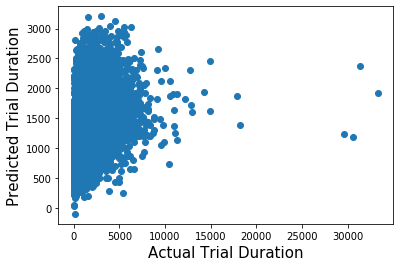

In [76]:

plt.scatter(y_test, y_predicted)
plt.xlabel('Actual Trial Duration', fontsize=15)
plt.ylabel('Predicted Trial Duration', fontsize=15)
plt.show()

In [77]:
y_log = np.log(trials_df['duration_days'])

x_train, x_test, ylog_train, ylog_test = train_test_split(x, y_log, train_size=0.8, test_size=0.2, random_state = 5)


In [78]:
model = LinearRegression()
model.fit(x_train, ylog_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
ylog_predicted = model.predict(x_test)

In [80]:
model.score(x_train, ylog_train)

0.17312014582341828

In [81]:
model.score(x_test, ylog_test)

0.17588378024527174

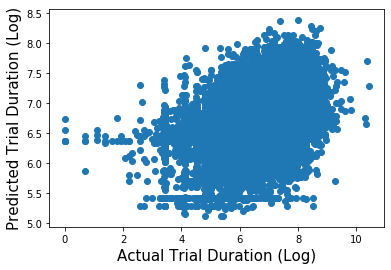

In [83]:
plt.scatter(ylog_test, ylog_predicted)
plt.xlabel('Actual Trial Duration (Log)', fontsize=15)
plt.ylabel('Predicted Trial Duration (Log)', fontsize=15)
plt.show()

#### Logistic Regression

In [90]:
# Trial duration set to 1 or 0. 
trials_df['duration_classified'] = trials_df['duration_days'].apply(lambda x: 1 if x >= 1004 else 0)


In [91]:
x_logistic = trials_df[features_allnormalized]
y_logistic = trials_df['duration_classified']

xlogistic_train, xlogistic_test, ylogistic_train, ylogistic_test = train_test_split(x_logistic, y_logistic, train_size=0.8, test_size=0.2, random_state = 5)


In [92]:
model = LogisticRegression()
model.fit(xlogistic_train, ylogistic_train)
ylogistic_predicted = model.predict(xlogistic_test)

In [93]:
model.score(xlogistic_train, ylogistic_train)

0.6323245880335325

In [94]:
model.score(xlogistic_test, ylogistic_test)

0.6354069024286323

In [95]:
print(accuracy_score(ylogistic_test, ylogistic_predicted))

print(precision_score(ylogistic_test, ylogistic_predicted))

print(recall_score(ylogistic_test, ylogistic_predicted))

print(f1_score(ylogistic_test, ylogistic_predicted))

0.6354069024286323
0.6549917531774522
0.5744554118447924
0.6120857699805068


#### Support Vector Machine

In [98]:
classifier = LinearSVC()
classifier.fit(xlogistic_train, ylogistic_train)

ylogistic_predicted = classifier.predict(xlogistic_test)
classifier.score(xlogistic_train, ylogistic_train)
classifier.score(xlogistic_test, ylogistic_test)

print(accuracy_score(ylogistic_test, ylogistic_predicted))

print(precision_score(ylogistic_test, ylogistic_predicted))

print(recall_score(ylogistic_test, ylogistic_predicted))

print(f1_score(ylogistic_test, ylogistic_predicted))

0.6337878142309331
0.6558704453441295
0.5651803948264126
0.6071575483340189


//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Random forest

In [97]:
clf = RandomForestClassifier(random_state=0)
clf.fit(xlogistic_train, ylogistic_train)
print(clf.feature_importances_)
ylogistic_predicted = clf.predict(xlogistic_test)
clf.score(xlogistic_train, ylogistic_train)
clf.score(xlogistic_test, ylogistic_test)

print(accuracy_score(ylogistic_test, ylogistic_predicted))

print(precision_score(ylogistic_test, ylogistic_predicted))

print(recall_score(ylogistic_test, ylogistic_predicted))

print(f1_score(ylogistic_test, ylogistic_predicted))

[0.01451042 0.00723578 0.00339662 0.01418866 0.01441226 0.01090984
 0.00758776 0.00644851 0.01325149 0.00848768 0.06024288 0.00105295
 0.01136071 0.00483334 0.00288343 0.0081411  0.00340413 0.00951872
 0.00106355 0.01048527 0.00429822 0.00792123 0.00439892 0.00648967
 0.01098732 0.01101777 0.01484379 0.00894583 0.00363029 0.00995561
 0.01253269 0.00607186 0.00723246 0.00315837 0.00503082 0.00360189
 0.00246332 0.00373064 0.00416668 0.00169328 0.00571782 0.00696884
 0.00345349 0.01628989 0.0112677  0.00941131 0.00800641 0.00597353
 0.00321961 0.01073316 0.00550288 0.01693739 0.37965523 0.17127699]
0.6521942905837239
0.6548985757444972
0.6455922396187883
0.650212109525646
